In [1]:
import copy,random
import numpy as np
from deap import tools

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
import matplotlib.patches as patches

In [3]:
#individual class 
class individual(list):
    def __init__(self, data):
        list.__init__(self, data)
        
        self.value = tuple(data)
        self.level = sum(self)
        
    def level(self):
        return self.level
    #def value(self):
       # return self.value

In [4]:
#reference_point class
class reference_point(list):
     def __init__(self, data):
        list.__init__(self, data)
        
        self.associations_count =0 # update de niche number
        self.associations = []
        #self.value = data
def associations(self):
        return self.associations
def associations_count(self):
        return associations_count

In [5]:
#make reference_point
from scipy.special import comb
from itertools import combinations
import numpy as np
import copy
import math
def uniformpoint(num_of_refpoitns,num_of_objs):
    H1=1
    while (comb(H1+num_of_objs-1,num_of_objs-1)<=num_of_refpoitns):
        H1=H1+1
    H1=H1-1
    refpoints=np.array(list(combinations(range(H1+num_of_objs-1),num_of_objs-1)))-np.tile(np.array(list(range(num_of_objs-1))),(int(comb(H1+num_of_objs-1,num_of_objs-1)),1))
    refpoints=(np.hstack((refpoints,H1+np.zeros((refpoints.shape[0],1))))-np.hstack((np.zeros((refpoints.shape[0],1)),refpoints)))/H1
    if H1<num_of_objs:
        H2=0
        while(comb(H1+num_of_objs-1,num_of_objs-1)+comb(H2+num_of_objs-1,num_of_objs-1) <= num_of_refpoitns):
            H2=H2+1
        H2=H2-1
        if H2>0:
            refpoints2=np.array(list(combinations(range(H2+num_of_objs-1),num_of_objs-1)))-np.tile(np.array(list(range(num_of_objs-1))),(int(comb(H2+num_of_objs-1,num_of_objs-1)),1))
            refpoints2=(np.hstack((refpoints2,H2+np.zeros((refpoints2.shape[0],1))))-np.hstack((np.zeros((refpoints2.shape[0],1)),refpoints2)))/H2
            refpoints2=refpoints2/2+1/(2*num_of_objs)
            refpoints=np.vstack((refpoints,refpoints2))#按列合并
    refpoints[refpoints<1e-6]=1e-6
    num_of_refpoitns=refpoints.shape[0]
    
    refps = []
    for i in refpoints:
        refps.append(reference_point(i))
    return refps,num_of_refpoitns

In [6]:
#find ideal point
def find_ideal_point(individuals):
    'Finds the ideal point from a set individuals.'
    ideal_point = [np.infty] * len(individuals[0])
    for each in individuals:
        ideal_point = np.minimum(ideal_point,each)
    return ideal_point

In [7]:
#find ex point
def find_extreme_points(individuals):
    return [sorted(individuals, key=lambda ind:ind[obj])[-1]
            for obj in range(len(individuals[0]))]

In [8]:
#find intercept
def construct_hyperplane(individuals, extreme_points):
    def has_duplicate_individuals(individuals):
        for i in range(len(individuals)):
            for j in range(i+1, len(individuals)):
                if (individuals[i]==individuals[j]):
                    return True
        return False

    num_objs = len(individuals[0])

    if has_duplicate_individuals(extreme_points):
        intercepts = [extreme_points[m] for m in range(num_objs)]
    else:
        b = np.ones(num_objs)
        A = [point for point in extreme_points]
        x = np.linalg.solve(A,b)
        #print(x)
        intercepts = 1/x
    return intercepts

In [9]:
#normalize 
def normalize_objective(individual, m, intercepts, ideal_point, epsilon=1e-20):
    'Normalizes an objective.'
    # Numeric trick present in JMetal implementation.
    #if np.abs(max(intercepts[m])-ideal_point[m] > epsilon):

    return individual[m] / (intercepts[m]-ideal_point[m]) 
   # else:
    #    return individual[m] / epsilon

In [10]:
#add normalized_values to individual
def normalize_objectives(individuals, intercepts, ideal_point):
   
    num_objs = len(individuals[0])

    for ind in individuals:
        ind.normalized_values = list([normalize_objective(ind, m,intercepts, ideal_point)for m in range(num_objs)])
    return individuals

In [11]:
#calculate distence 
def perpendicular_distance(direction, point):
    k = np.dot(direction, point) / np.sum(np.power(direction, 2))
    d = np.sum(np.power(np.subtract(np.multiply(direction, [k] * len(direction)), point) , 2))
    return np.sqrt(d)

In [12]:
#associate
def associate(individuals, reference_points):
   
    if len(individuals)!=0:
        num_objs = len(individuals[0])

        for ind in individuals:
            rp_dists = [(rp, perpendicular_distance(ind.normalized_values, rp))
                        for rp in reference_points]
            best_rp, best_dist = sorted(rp_dists, key=lambda rpd:rpd[1])[0]
            ind.reference_point = best_rp
            ind.ref_point_distance = best_dist
            best_rp.associations_count +=1 # update de niche number
            best_rp.associations += [ind]

In [13]:
#non dominated sort

import bisect
from operator import attrgetter, itemgetter
from collections import defaultdict, namedtuple
def sortLogNondominated(individuals, k, first_front_only=False):
    """Sort *individuals* in pareto non-dominated fronts using the Generalized
    Reduced Run-Time Complexity Non-Dominated Sorting Algorithm presented by
    Fortin et al. (2013).
    :param individuals: A list of individuals to select from.
    :returns: A list of Pareto fronts (lists), with the first list being the
              true Pareto front.
    """
    if k == 0:
        return []

    #Separate individuals according to unique fitnesses
    unique_fits = defaultdict(list)
    for i, ind in enumerate(individuals):
        unique_fits[ind.value].append(ind)

    #Launch the sorting algorithm
    obj = len(individuals[0])-1
    fitnesses = list(unique_fits.keys())
    front = dict.fromkeys(fitnesses, 0)

    # Sort the fitnesses lexicographically.
    fitnesses.sort(reverse=True)
    sortNDHelperA(fitnesses, obj, front)

    #Extract individuals from front list here
    nbfronts = max(front.values())+1
    pareto_fronts = [[] for i in range(nbfronts)]
    for fit in fitnesses:
        index = front[fit]
        pareto_fronts[index].extend(unique_fits[fit])

    # Keep only the fronts required to have k individuals.
    if not first_front_only:
        count = 0
        for i, front in enumerate(pareto_fronts):
            count += len(front)
            if count >= k:
                return pareto_fronts[:i+1]
        return pareto_fronts
    else:
        return pareto_fronts[0]

def sortNDHelperA(fitnesses, obj, front):
    """Create a non-dominated sorting of S on the first M objectives"""
    if len(fitnesses) < 2:
        return
    elif len(fitnesses) == 2:
        # Only two individuals, compare them and adjust front number
        s1, s2 = fitnesses[0], fitnesses[1]
        if isDominated(s2[:obj+1], s1[:obj+1]):
            front[s2] = max(front[s2], front[s1] + 1)
    elif obj == 1:
        sweepA(fitnesses, front)
    elif len(frozenset(list(map(itemgetter(obj), fitnesses)))) == 1:
        #All individuals for objective M are equal: go to objective M-1
        sortNDHelperA(fitnesses, obj-1, front)
    else:
        # More than two individuals, split list and then apply recursion
        best, worst = splitA(fitnesses, obj)
        sortNDHelperA(best, obj, front)
        sortNDHelperB(best, worst, obj-1, front)
        sortNDHelperA(worst, obj, front)

def splitA(fitnesses, obj):
    """Partition the set of fitnesses in two according to the median of
    the objective index *obj*. The values equal to the median are put in
    the set containing the least elements.
    """
    median_ = median(fitnesses, itemgetter(obj))
    best_a, worst_a = [], []
    best_b, worst_b = [], []

    for fit in fitnesses:
        if fit[obj] > median_:
            best_a.append(fit)
            best_b.append(fit)
        elif fit[obj] < median_:
            worst_a.append(fit)
            worst_b.append(fit)
        else:
            best_a.append(fit)
            worst_b.append(fit)

    balance_a = abs(len(best_a) - len(worst_a))
    balance_b = abs(len(best_b) - len(worst_b))

    if balance_a <= balance_b:
        return best_a, worst_a
    else:
        return best_b, worst_b

def sweepA(fitnesses, front):
    """Update rank number associated to the fitnesses according
    to the first two objectives using a geometric sweep procedure.
    """
    stairs = [-fitnesses[0][1]]
    fstairs = [fitnesses[0]]
    for fit in fitnesses[1:]:
        idx = bisect.bisect_right(stairs, -fit[1])
        if 0 < idx <= len(stairs):
            fstair = max(fstairs[:idx], key=front.__getitem__)
            front[fit] = max(front[fit], front[fstair]+1)
        for i, fstair in enumerate(fstairs[idx:], idx):
            if front[fstair] == front[fit]:
                del stairs[i]
                del fstairs[i]
                break
        stairs.insert(idx, -fit[1])
        fstairs.insert(idx, fit)

def sortNDHelperB(best, worst, obj, front):
    """Assign front numbers to the solutions in H according to the solutions
    in L. The solutions in L are assumed to have correct front numbers and the
    solutions in H are not compared with each other, as this is supposed to
    happen after sortNDHelperB is called."""
    key = itemgetter(obj)
    if len(worst) == 0 or len(best) == 0:
        #One of the lists is empty: nothing to do
        return
    elif len(best) == 1 or len(worst) == 1:
        #One of the lists has one individual: compare directly
        for hi in worst:
            for li in best:
                if isDominated(hi[:obj+1], li[:obj+1]) or hi[:obj+1] == li[:obj+1]:
                    front[hi] = max(front[hi], front[li] + 1)
    elif obj == 1:
        sweepB(best, worst, front)
    elif key(min(best, key=key)) >= key(max(worst, key=key)):
        #All individuals from L dominate H for objective M:
        #Also supports the case where every individuals in L and H
        #has the same value for the current objective
        #Skip to objective M-1
        sortNDHelperB(best, worst, obj-1, front)
    elif key(max(best, key=key)) >= key(min(worst, key=key)):
        best1, best2, worst1, worst2 = splitB(best, worst, obj)
        sortNDHelperB(best1, worst1, obj, front)
        sortNDHelperB(best1, worst2, obj-1, front)
        sortNDHelperB(best2, worst2, obj, front)

def splitB(best, worst, obj):
    """Split both best individual and worst sets of fitnesses according
    to the median of objective *obj* computed on the set containing the
    most elements. The values equal to the median are attributed so as
    to balance the four resulting sets as much as possible.
    """
    median_ = median(best if len(best) > len(worst) else worst, itemgetter(obj))
    best1_a, best2_a, best1_b, best2_b = [], [], [], []
    for fit in best:
        if fit[obj] > median_:
            best1_a.append(fit)
            best1_b.append(fit)
        elif fit[obj] < median_:
            best2_a.append(fit)
            best2_b.append(fit)
        else:
            best1_a.append(fit)
            best2_b.append(fit)

    worst1_a, worst2_a, worst1_b, worst2_b = [], [], [], []
    for fit in worst:
        if fit[obj] > median_:
            worst1_a.append(fit)
            worst1_b.append(fit)
        elif fit[obj] < median_:
            worst2_a.append(fit)
            worst2_b.append(fit)
        else:
            worst1_a.append(fit)
            worst2_b.append(fit)

    balance_a = abs(len(best1_a) - len(best2_a) + len(worst1_a) - len(worst2_a))
    balance_b = abs(len(best1_b) - len(best2_b) + len(worst1_b) - len(worst2_b))

    if balance_a <= balance_b:
        return best1_a, best2_a, worst1_a, worst2_a
    else:
        return best1_b, best2_b, worst1_b, worst2_b

def sweepB(best, worst, front):
    """Adjust the rank number of the worst fitnesses according to
    the best fitnesses on the first two objectives using a sweep
    procedure.
    """
    stairs, fstairs = [], []
    iter_best = iter(best)
    next_best = next(iter_best, False)
    for h in worst:
        while next_best and h[:2] <= next_best[:2]:
            insert = True
            for i, fstair in enumerate(fstairs):
                if front[fstair] == front[next_best]:
                    if fstair[1] > next_best[1]:
                        insert = False
                    else:
                        del stairs[i], fstairs[i]
                    break
            if insert:
                idx = bisect.bisect_right(stairs, -next_best[1])
                stairs.insert(idx, -next_best[1])
                fstairs.insert(idx, next_best)
            next_best = next(iter_best, False)

        idx = bisect.bisect_right(stairs, -h[1])
        if 0 < idx <= len(stairs):
            fstair = max(fstairs[:idx], key=front.__getitem__)
            front[h] = max(front[h], front[fstair]+1)
def isDominated(wvalues1, wvalues2):
    """Returns whether or not *wvalues1* dominates *wvalues2*.

    :param wvalues1: The weighted fitness values that would be dominated.
    :param wvalues2: The weighted fitness values of the dominant.
    :returns: :obj:`True` if wvalues2 dominates wvalues1, :obj:`False`
              otherwise.
    """
    not_equal = False
    for self_wvalue, other_wvalue in zip(wvalues1, wvalues2):
        if self_wvalue > other_wvalue:
            return False
        elif self_wvalue < other_wvalue:
            not_equal = True
    return not_equal
def identity(obj):
    """Returns directly the argument *obj*.
    """
    return obj
def median(seq, key=identity):
    """Returns the median of *seq* - the numeric value separating the higher
    half of a sample from the lower half. If there is an even number of
    elements in *seq*, it returns the mean of the two middle values.
    """
    sseq = sorted(seq, key=key)
    length = len(seq)
    if length % 2 == 1:
        return key(sseq[(length - 1) // 2])
    else:
        return (key(sseq[(length - 1) // 2]) + key(sseq[length // 2])) / 2.0

In [14]:
#select
def niching_select(individuals, k, num_of_refpoitns, selection):
    '''Secondary niched selection based on reference points. Corresponds to
    steps 13-17 of Algorithm 1 and to Algorithm 4.'''
    #print(selection)
    if len(individuals) == k:
        return individuals

    #individuals = copy.deepcopy(individuals)

    ideal_point = find_ideal_point(individuals)
    extremes = find_extreme_points(individuals)
    intercepts = construct_hyperplane(individuals, extremes)
    normalize_objectives(individuals, intercepts, ideal_point)

    reference_points, num_reference_points = uniformpoint(
        num_of_refpoitns, len(individuals[0]))

    reference_points_before_l = copy.deepcopy(reference_points)
    associate(individuals, reference_points)
    associate(selection,reference_points_before_l)
    res = []
    while len(res) < k:
        min_assoc_rp = min(reference_points_before_l,
                           key=lambda rp: rp.associations_count)
        min_assoc_rps = [
            rp for rp in reference_points_before_l
            if rp.associations_count == min_assoc_rp.associations_count
        ]
        chosen_rp = min_assoc_rps[random.randint(0, len(min_assoc_rps)-1 )]

        #print('Rps',min_assoc_rp.associations_count, chosen_rp.associations_count, len(min_assoc_rps))

        associated_inds = chosen_rp.associations
        
        #if chosen_rp.associations:
        if chosen_rp.associations_count == 0:
            #sel = min(chosen_rp.associations,key=lambda ind: ind.ref_point_distance)
            if reference_points[reference_points.index(chosen_rp)].associations:
                sel = min(reference_points[reference_points.index(chosen_rp)].associations,key=lambda ind: ind.ref_point_distance)
                res += [sel]
                reference_points_before_l[reference_points_before_l.index(chosen_rp)].associations_count += 1
            else:
                reference_points_before_l.remove(chosen_rp)
        else:
            sel = reference_points[reference_points.index(chosen_rp)].associations[random.randint(0,len(reference_points[reference_points.index(chosen_rp)].associations) - 1)]
            res += [sel]
            reference_points_before_l[reference_points_before_l.index(chosen_rp)].associations_count += 1
        #res += [sel]
        #chosen_rp.associations.remove(sel)
        #reference_points_before_l[reference_points_before_l.index(chosen_rp)].associations_count += 1
        #print(sel)
        #print("sel" in locals())
        judge = "sel" in locals()
        if judge :
            if individuals.count(sel):
                individuals.remove(sel)
        
    return res, ideal_point, extremes, intercepts, reference_points,num_reference_points

In [15]:
#main
def sel_nsga_iii(individuals, k, num_of_refpoitns):

    assert len(individuals) >= k

    if len(individuals) == k:
        return individuals

    # Algorithm 1 steps 4--8
    fronts = sortLogNondominated(individuals, len(individuals))

    limit = 0
    res = []
    for f, front in enumerate(fronts):
        res += front
        if len(res) > k:
            limit = f
            break
    # Algorithm 1 steps
    selection = []
    if limit > 0:
        for f in range(limit):
            selection += fronts[f]
            #print(selection)
    # complete selected inividuals using the referece point based approach
    selection += niching_select(fronts[limit], k - len(selection),
                                num_of_refpoitns,selection)
    return selection

In [16]:
#IGD index
def compute_IGD(individuals):
    IGD_index = sum([np.sqrt(np.sum(np.square(np.array(ind.normalized_values)-np.array(ind.reference_point))))for ind in individuals])/len(individuals)
    return IGD_index

In [17]:
#20runs for triangle
inds = np.loadtxt('3D-triangle.txt')
individuals = []
for i in range(20):
    for ind in inds:
        individuals.append(individual(ind))
    pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,100)
    IGD_index = compute_IGD(pop)
    print(IGD_index)

0.003934652969989111
0.00393465296998911
0.003934652969989114
0.003934652969989114
0.00393465296998911
0.003934652969989112
0.003934652969989114
0.00393465296998911
0.0039346529699891145
0.003934652969989112
0.003934652969989113
0.003934652969989112
0.003934652969989113
0.00393465296998911
0.003934652969989111
0.003934652969989113
0.003934652969989112
0.00393465296998911
0.003934652969989113
0.003934652969989112


In [22]:
#1run for triangle
inds = np.loadtxt('3D-triangle.txt')
individuals = []
for ind in inds:
    individuals.append(individual(ind))
pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,91)
num_reference_points

91

In [23]:
reference_points

[[1e-06, 1e-06, 1.0],
 [1e-06, 0.08333333333333333, 0.9166666666666666],
 [1e-06, 0.16666666666666666, 0.8333333333333334],
 [1e-06, 0.25, 0.75],
 [1e-06, 0.3333333333333333, 0.6666666666666666],
 [1e-06, 0.4166666666666667, 0.5833333333333334],
 [1e-06, 0.5, 0.5],
 [1e-06, 0.5833333333333334, 0.4166666666666667],
 [1e-06, 0.6666666666666666, 0.3333333333333333],
 [1e-06, 0.75, 0.25],
 [1e-06, 0.8333333333333334, 0.16666666666666666],
 [1e-06, 0.9166666666666666, 0.08333333333333333],
 [1e-06, 1.0, 1e-06],
 [0.08333333333333333, 1e-06, 0.9166666666666666],
 [0.08333333333333333, 0.08333333333333333, 0.8333333333333334],
 [0.08333333333333333, 0.16666666666666666, 0.75],
 [0.08333333333333333, 0.25, 0.6666666666666666],
 [0.08333333333333333, 0.3333333333333333, 0.5833333333333334],
 [0.08333333333333333, 0.4166666666666667, 0.5],
 [0.08333333333333333, 0.5, 0.4166666666666667],
 [0.08333333333333333, 0.5833333333333334, 0.3333333333333333],
 [0.08333333333333333, 0.6666666666666666, 0.

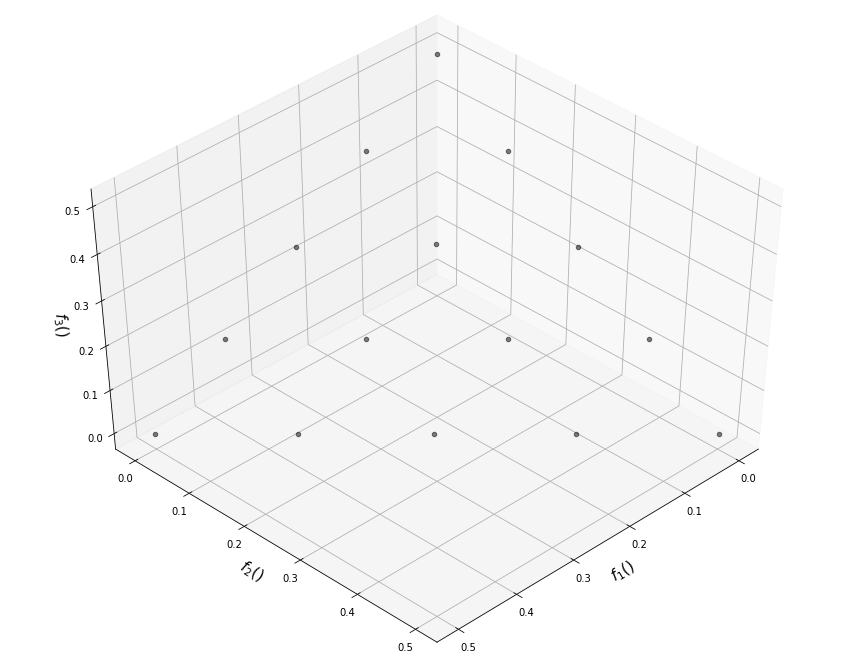

In [21]:
#Visualization of final set of tri
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)
    


# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

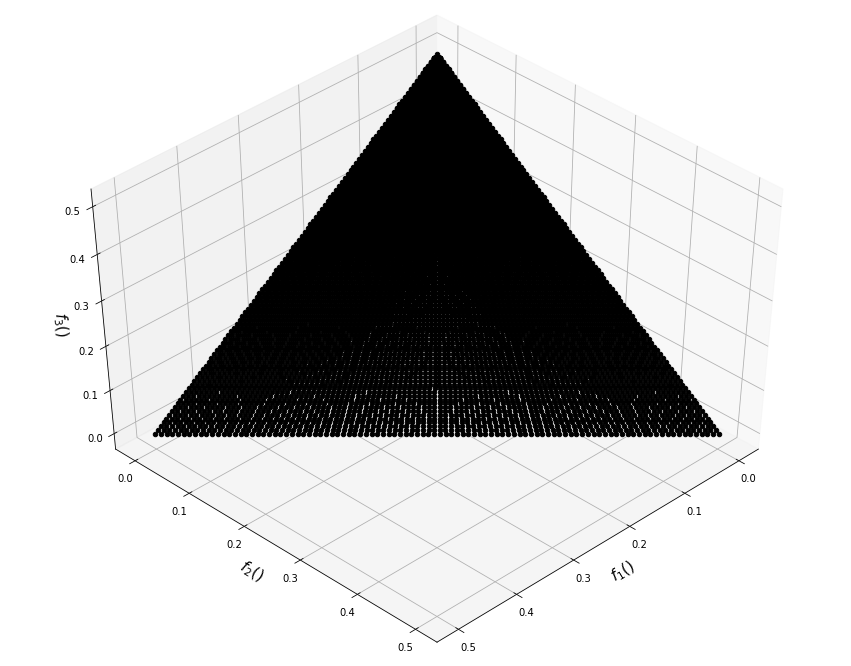

In [89]:
# Visualization of pop of tri
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
    
for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black")
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

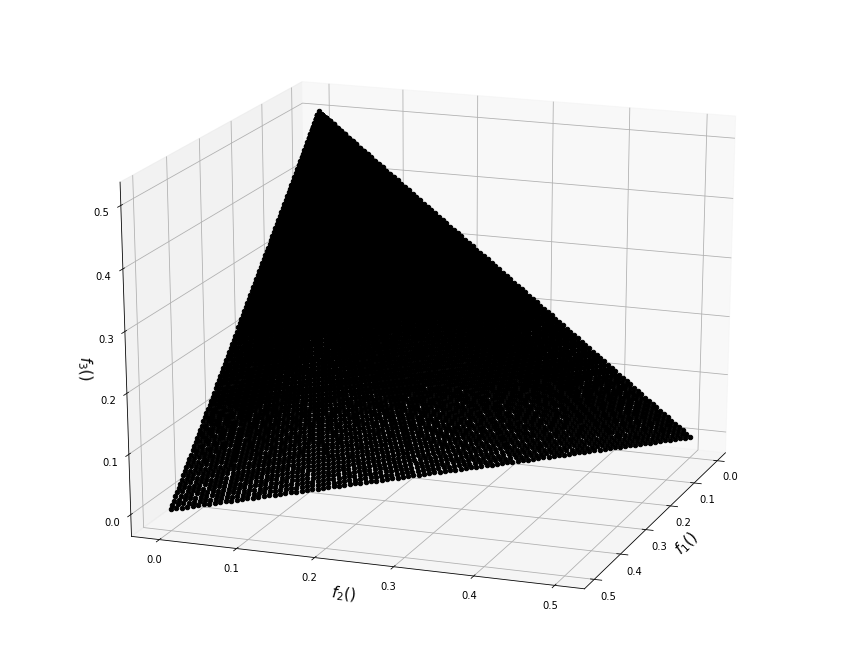

In [90]:
#Visualization of pop of tri
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')
    
for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black")
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

In [18]:
pop

[[0.2906846, 0.08305275, 0.1262626],
 [0.2515049, 0.04142434, 0.2070707],
 [0.04178145, 0.4178145, 0.04040404],
 [0.3768493, 0.04234262, 0.08080808],
 [0.2076319, 0.1661055, 0.1262626],
 [0.1245791, 0.2087542, 0.1666667],
 [0.1249872, 0.00127538, 0.3737374],
 [0.2117131, 0.2074788, 0.08080808],
 [0.2498214, 0.1693705, 0.08080808],
 [0.332211, 0.04152637, 0.1262626],
 [0.3737374, 0.0, 0.1262626],
 [0.04208754, 0.1245791, 0.3333333],
 [0.1245791, 0.04208754, 0.3333333],
 [0.08305275, 0.2906846, 0.1262626],
 [0.3345067, 0.08468524, 0.08080808],
 [0.3737374, 0.1262626, 0.0],
 [0.3333333, 0.1666667, 0.0],
 [0.1666667, 0.3333333, 0.0],
 [0.2087542, 0.1245791, 0.1666667],
 [0.5, 0.0, 0.0],
 [0.459596, 0.04040404, 0.0],
 [0.0, 0.04040404, 0.459596],
 [0.2929293, 0.0, 0.2070707],
 [0.0, 0.2070707, 0.2929293],
 [0.3760331, 0.0835629, 0.04040404],
 [0.08366493, 0.1234058, 0.2929293],
 [0.0, 0.5, 0.0],
 [0.0, 0.459596, 0.04040404],
 [0.1234058, 0.08366493, 0.2929293],
 [0.00255076, 0.2499745, 0.24

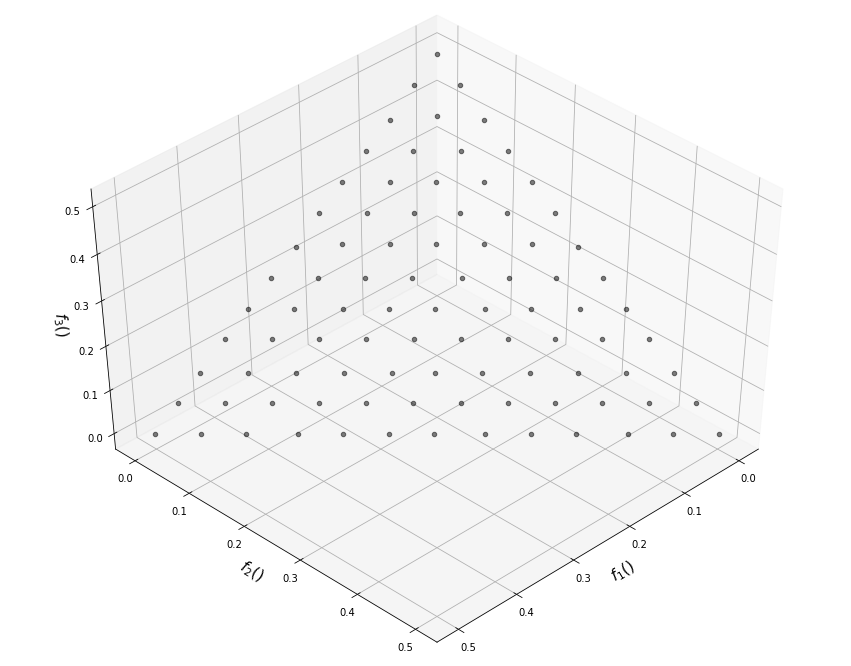

In [91]:
#Visualization of final set of tri
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)
    


# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

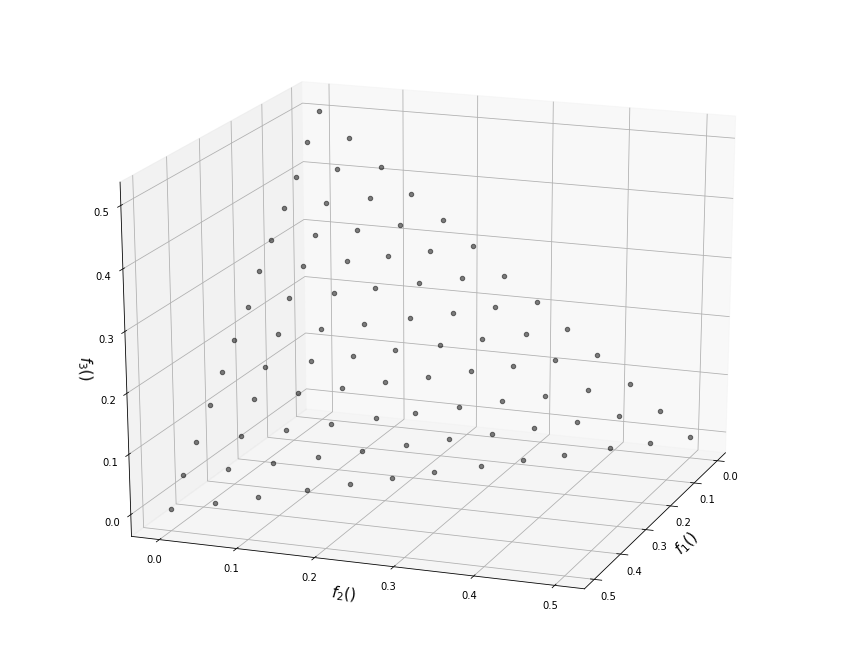

In [92]:
#Visualization of final pop of tri
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)
    


# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

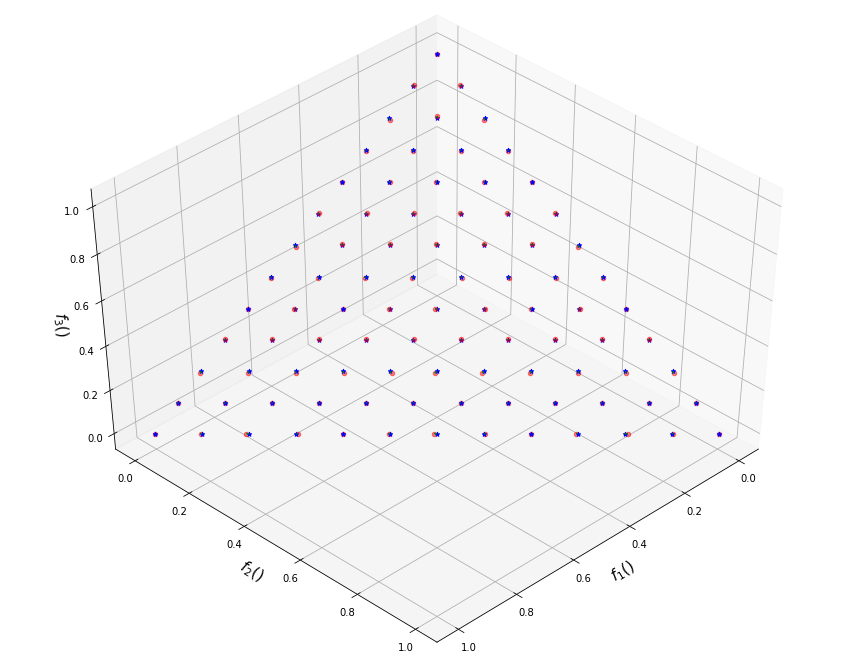

In [93]:
#Visualization of associated  of tri
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")
    
# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")

for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
   ax.scatter(ind.normalized_values[0], 
              ind.normalized_values[1], 
              ind.normalized_values[2], color='red', marker='o',alpha=0.5)
   pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

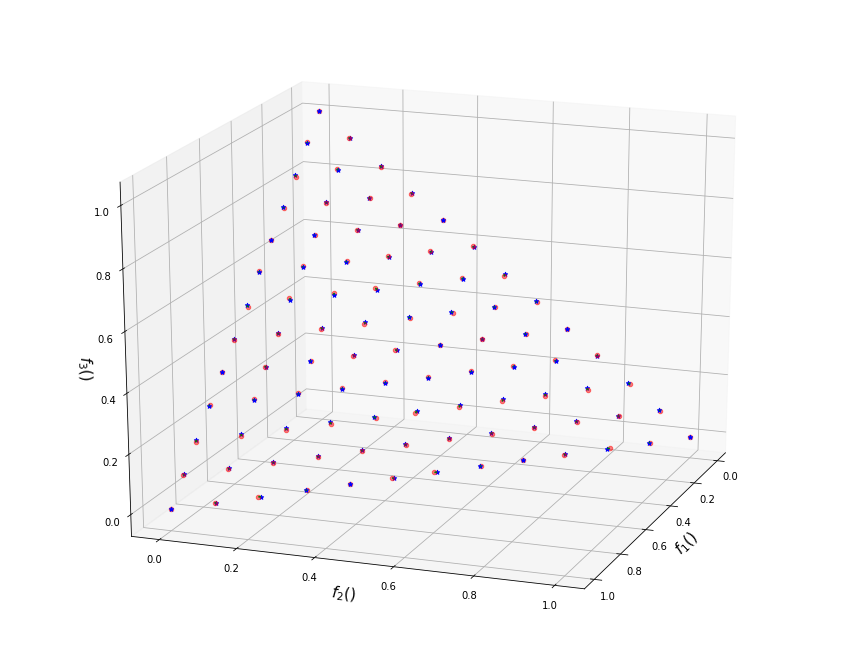

In [94]:
#Visualization of associated  of tri
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")
    
# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")

for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
   ax.scatter(ind.normalized_values[0], 
              ind.normalized_values[1], 
              ind.normalized_values[2], color='red', marker='o',alpha=0.5)
   pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

In [35]:
#20runs for circle
inds = np.loadtxt('3D-circle.txt')
individuals = []
for i in range(20):
    print(i,'th')
    for ind in inds:
        individuals.append(individual(ind))
    pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,100)
    IGD_index = compute_IGD(pop)
    print(IGD_index)

0 th
0.031305366109496024
1 th
0.031018669728661446
2 th
0.03185989425034146
3 th
0.031729784446146214
4 th
0.03182005840438866
5 th
0.032673193395143844
6 th
0.03091705473338635
7 th
0.031563662020810415
8 th
0.0313699567645872
9 th
0.030880015918840334
10 th
0.030847060251201708
11 th
0.030922995898606708
12 th
0.03216325479582191
13 th
0.030151546401008648
14 th
0.030303445081969842
15 th
0.03215324025660903
16 th
0.03064388964043624
17 th
0.02871935748267418
18 th
0.03308948360888833
19 th
0.03081475621553202


In [79]:
#1run for circle
inds = np.loadtxt('3D-circle.txt')
individuals = []
for ind in inds:
    individuals.append(individual(ind))
pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,100)
num_reference_points

91

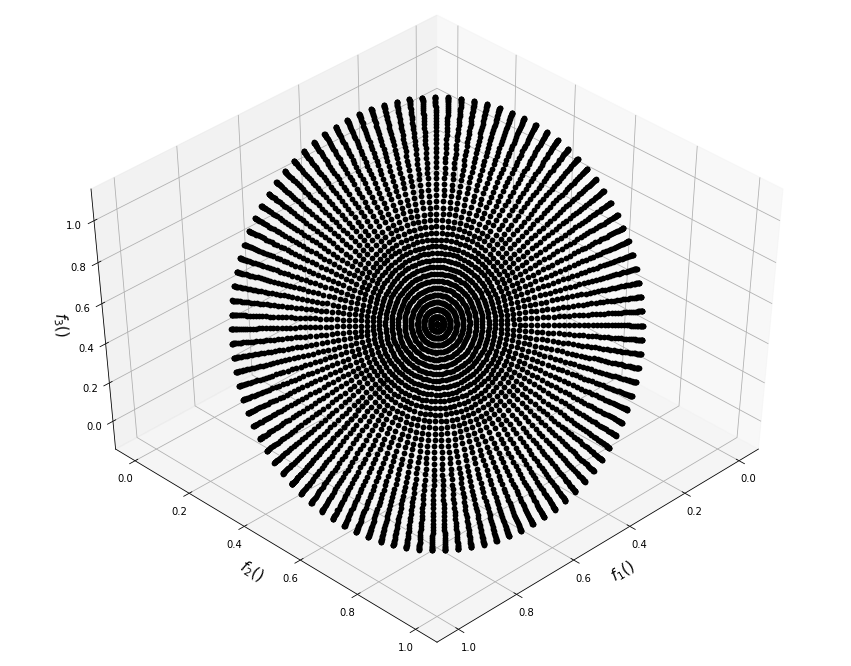

In [82]:
#Visualization of PF of circle
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')



for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black")

ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

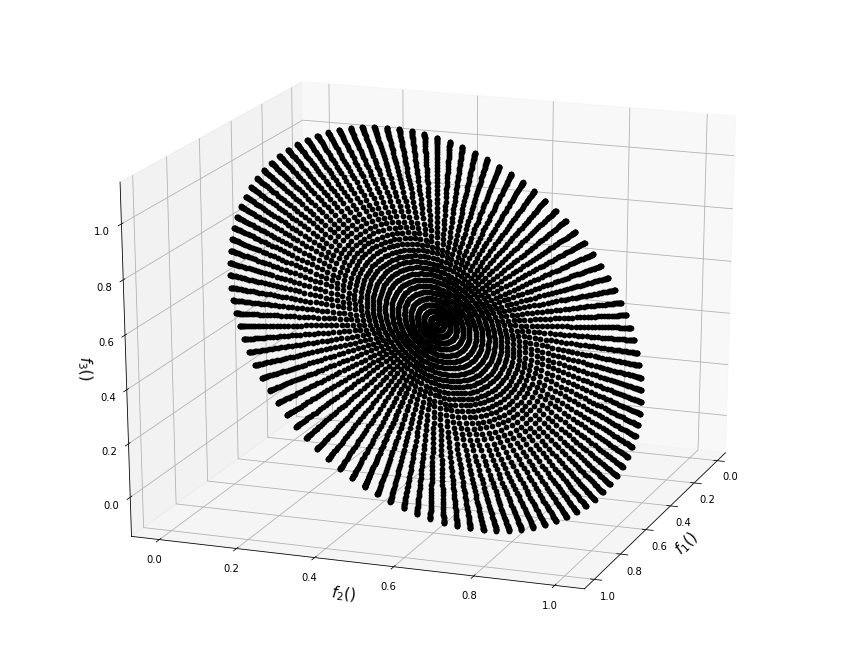

In [83]:
#Visualization of PF of cir
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')



for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black")

ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

91


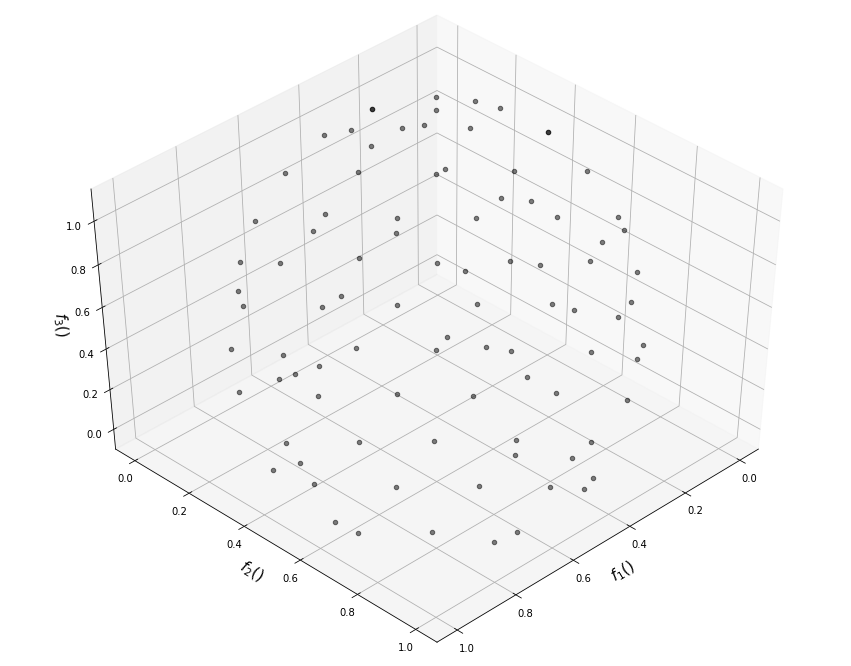

In [84]:
#Visualization of final pop of cir
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# # the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)
print(len(pop))

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

91


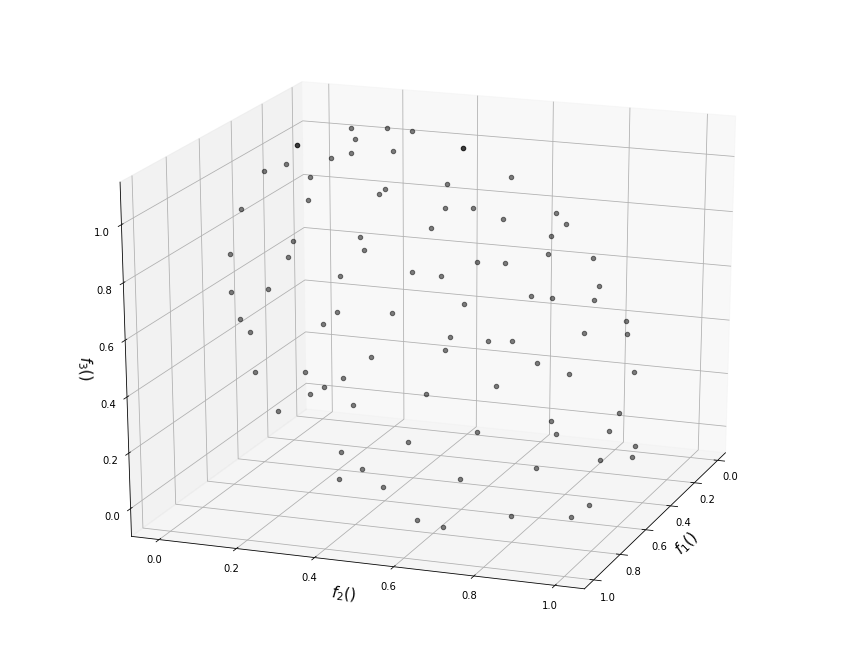

In [85]:
#Visualization of final pop of cir
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# # the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)
print(len(pop))

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

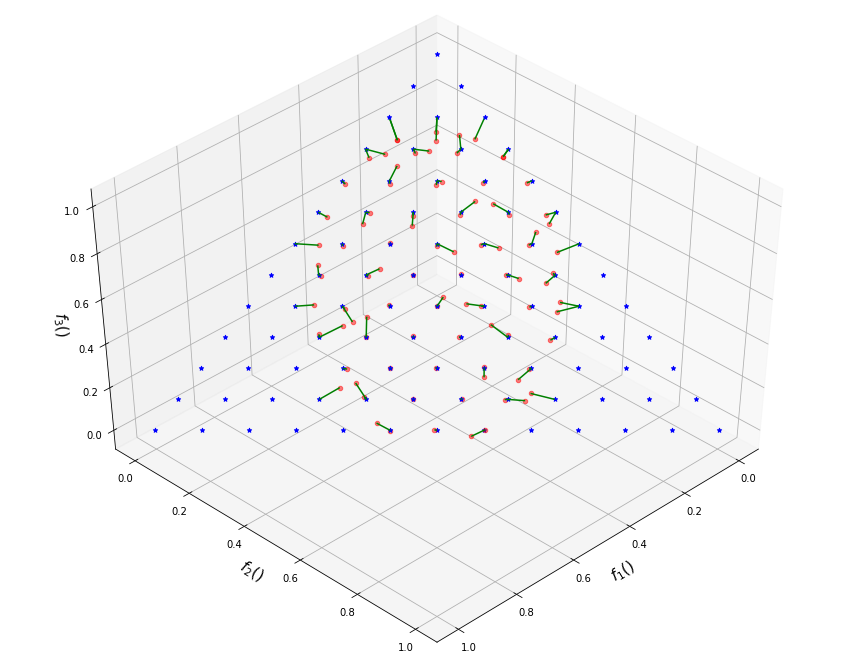

In [86]:
#Visualization of associated  of cir
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# # the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")
# print(len(pop))

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
    ax.scatter(ind.normalized_values[0], 
               ind.normalized_values[1], 
               ind.normalized_values[2], color='red', marker='o',alpha=0.5)
    pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

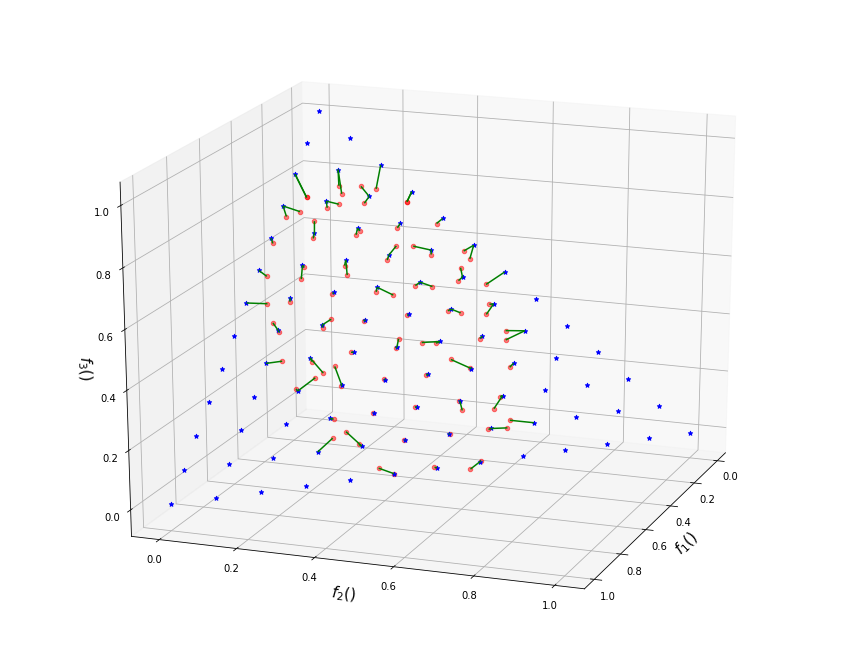

In [87]:
#Visualization of associated  of cir
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# # the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")
# print(len(pop))

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
    ax.scatter(ind.normalized_values[0], 
               ind.normalized_values[1], 
               ind.normalized_values[2], color='red', marker='o',alpha=0.5)
    pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

In [36]:
#20runs for quadrilateral
inds = np.loadtxt('3D-quadrilateral.txt')
individuals = []
for i in range(20):
    print(i,'th')
    for ind in inds:
        individuals.append(individual(ind))
    pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,100)
    IGD_index = compute_IGD(pop)
    print(IGD_index)

0 th
0.02189747700270616
1 th
0.020739030133553295
2 th
0.02188519071396807
3 th
0.02187052907897663
4 th
0.023978106878049237
5 th
0.021633992977830207
6 th
0.022044567466823078
7 th
0.02153109670141175
8 th
0.021584160580326518
9 th
0.023838095484413353
10 th
0.021614058291100947
11 th
0.02145428420278944
12 th
0.023094232047472896
13 th
0.02259798668572141
14 th
0.02267645245812708
15 th
0.020921192674020286
16 th
0.022843690533132278
17 th
0.02173646379753703
18 th
0.02323380721781861
19 th
0.022218622834329765


In [72]:
#1run for quadrilateral #Visualization of associated  of quadrilateral
inds = np.loadtxt('3D-quadrilateral.txt')
individuals = []
for ind in inds:
    individuals.append(individual(ind))
pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,100)
num_reference_points

91

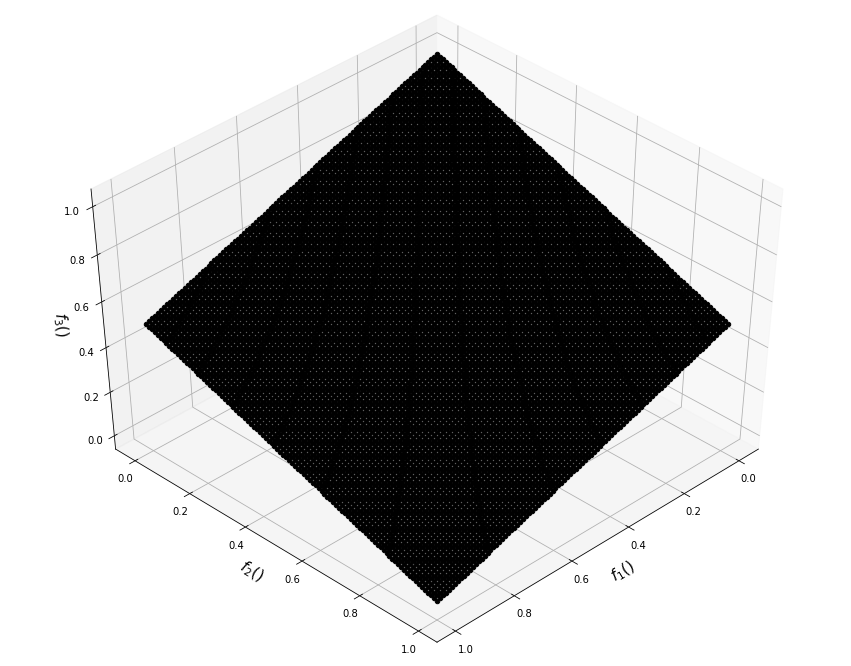

In [73]:
#Visualization of pop of quadrilateral
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black")


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

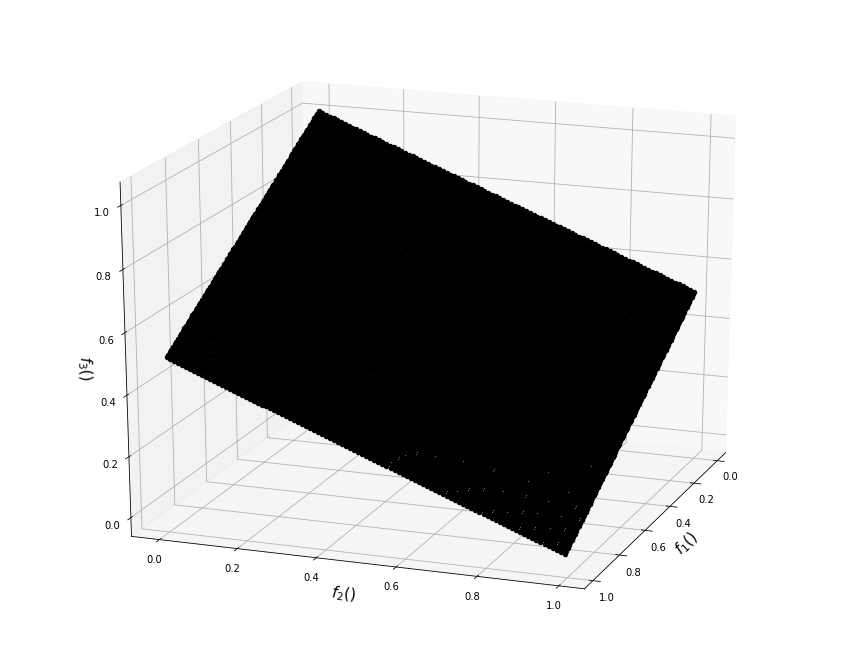

In [74]:
#Visualization of pop of quadrilateral
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black")


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

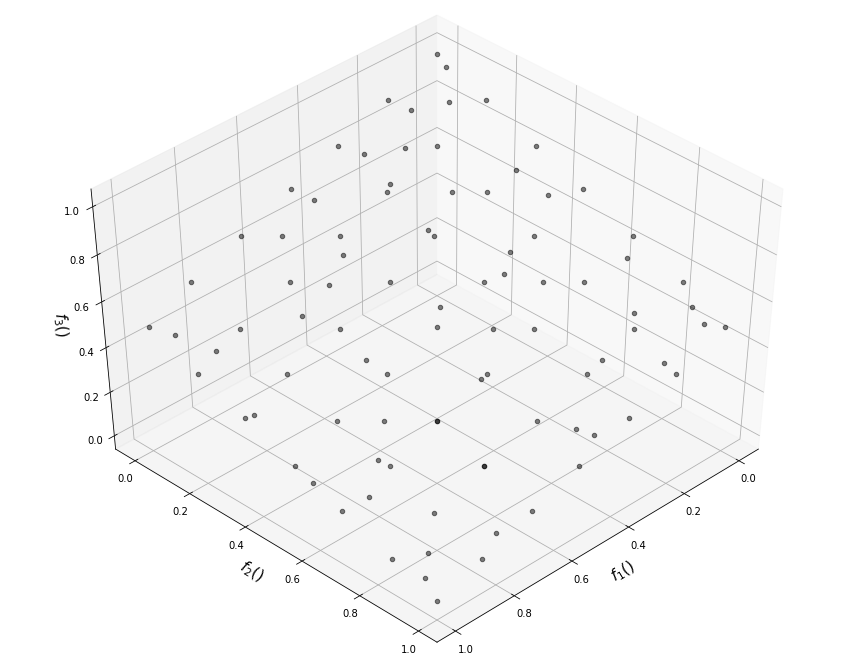

In [75]:
#Visualization of f pop of quadrilateral
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

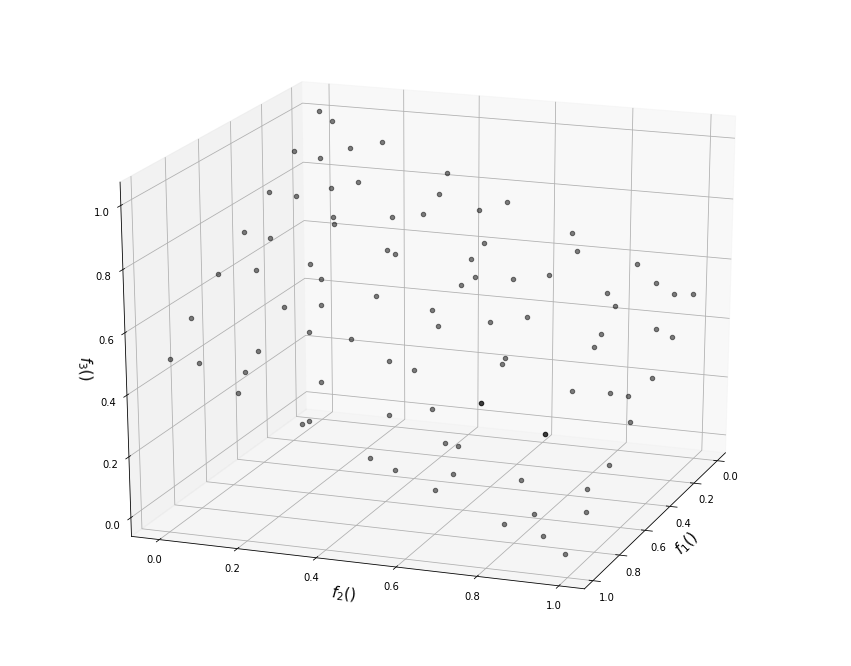

In [76]:
#Visualization of f pop of quadrilateral
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

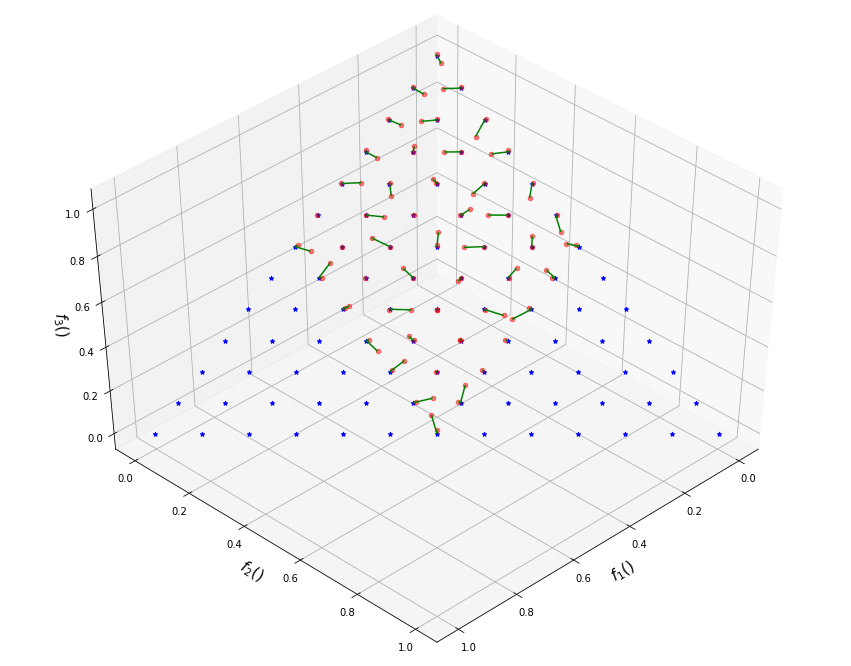

In [77]:
#Visualization of associated  of quadrilateral
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# # the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
    ax.scatter(ind.normalized_values[0], 
               ind.normalized_values[1], 
               ind.normalized_values[2], color='red', marker='o',alpha=0.5)
    pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

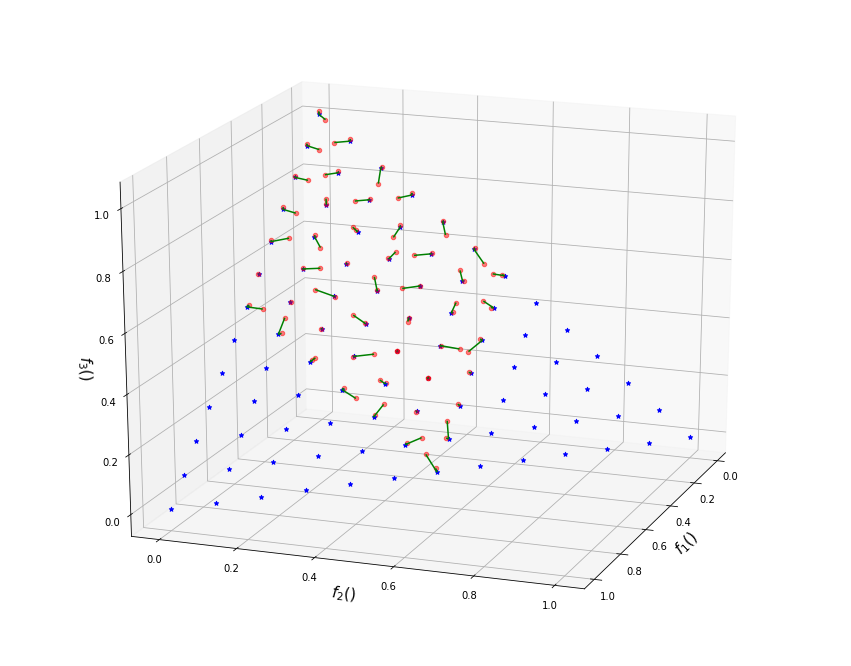

In [78]:
#Visualization of associated  of quadrilateral
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# # the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
    ax.scatter(ind.normalized_values[0], 
               ind.normalized_values[1], 
               ind.normalized_values[2], color='red', marker='o',alpha=0.5)
    pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

In [35]:
#20runs for lines
inds = np.loadtxt('3D-lines.txt')
individuals = []
for i in range(20):
    print(i,'th')
    for ind in inds:
        individuals.append(individual(ind))
    pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,100)
    IGD_index = compute_IGD(pop)
    print(IGD_index)

0 th
0.10939916792044933
1 th
0.10565258450266359
2 th
0.10784642817478551
3 th
0.11076214813582003
4 th
0.10884304168294434
5 th
0.10985074005199831
6 th
0.10960462009331552
7 th
0.10841664394180704
8 th
0.11265264549655395
9 th
0.1081745926755911
10 th
0.11186368484412057
11 th
0.1131208406276006
12 th
0.11565299392933322
13 th
0.11367918574967745
14 th
0.1085896066619442
15 th
0.10826813560960821
16 th
0.10762168695356202
17 th
0.10425443753042313
18 th
0.11086776502634488
19 th
0.11242846392319182


In [62]:
#1run for lines
inds = np.loadtxt('3D-lines.txt')
individuals = []
for ind in inds:
    individuals.append(individual(ind))
pop,ideal_point,extremes,intercepts,reference_points,num_reference_points=sel_nsga_iii(individuals,91,100)
num_reference_points

91

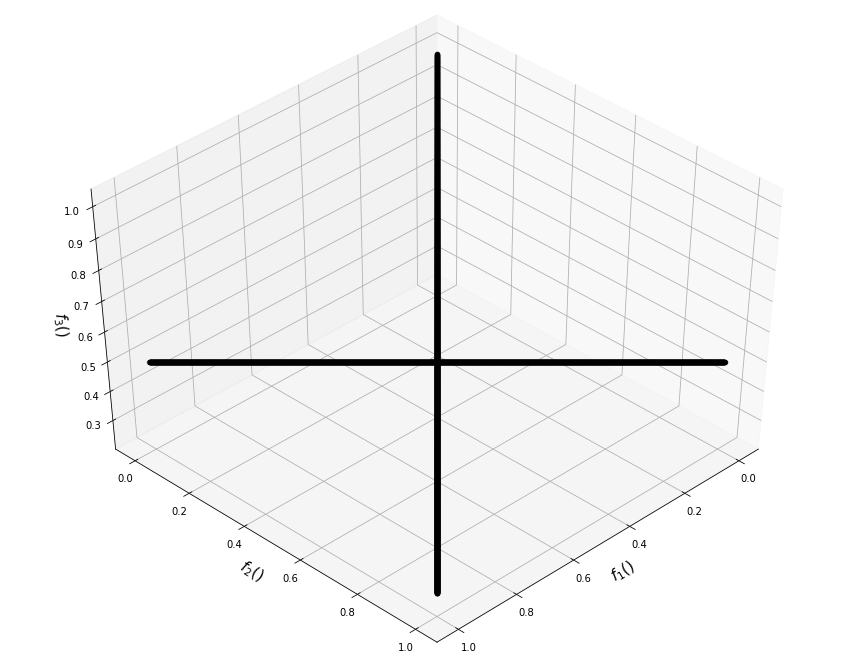

In [63]:
#Visualization of PF of lines
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

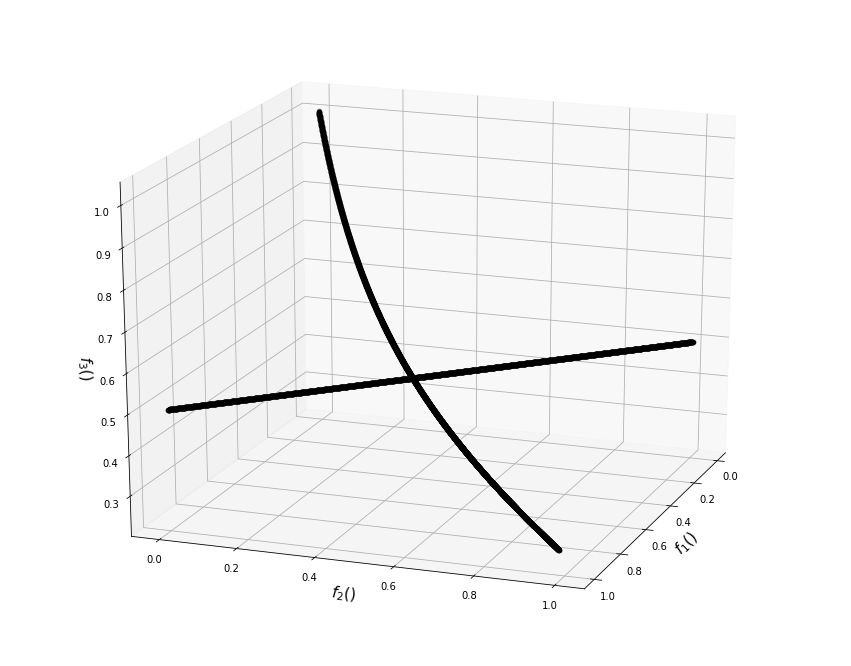

In [66]:
#Visualization of pf of lines
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

for ind in individuals:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

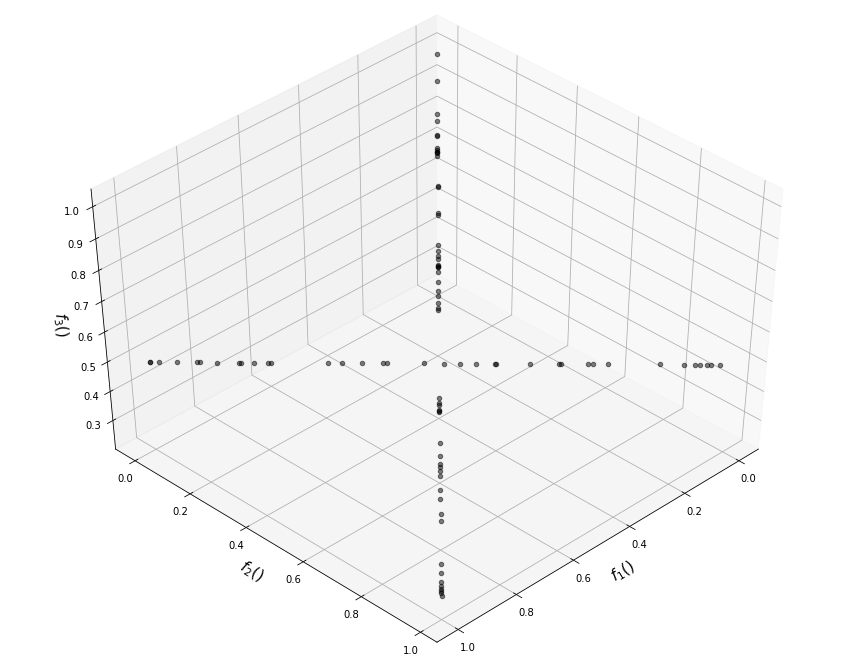

In [67]:
#Visualization of f pop of lines
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

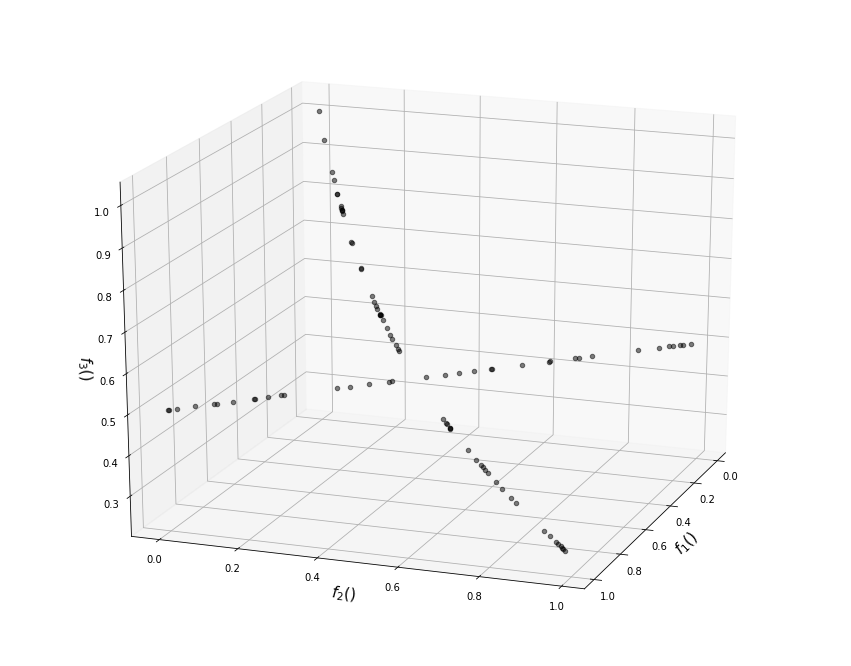

In [68]:
#Visualization of F pop of lines
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
#ax.scatter(0,0,0, c='k', marker='+', s=100)

for ind in pop:
    ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black",alpha=0.5)


# for rp in reference_points:
#     ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

# pairs = []
# for ind in pop:
#     ax.scatter(ind.normalized_values[0], 
#                ind.normalized_values[1], 
#                ind.normalized_values[2], color='red', marker='o')
#     pairs += [(ind.normalized_values, ind.reference_point)]

# lin = a3.art3d.Line3DCollection(pairs)
# lin.set_color('green')
# ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)

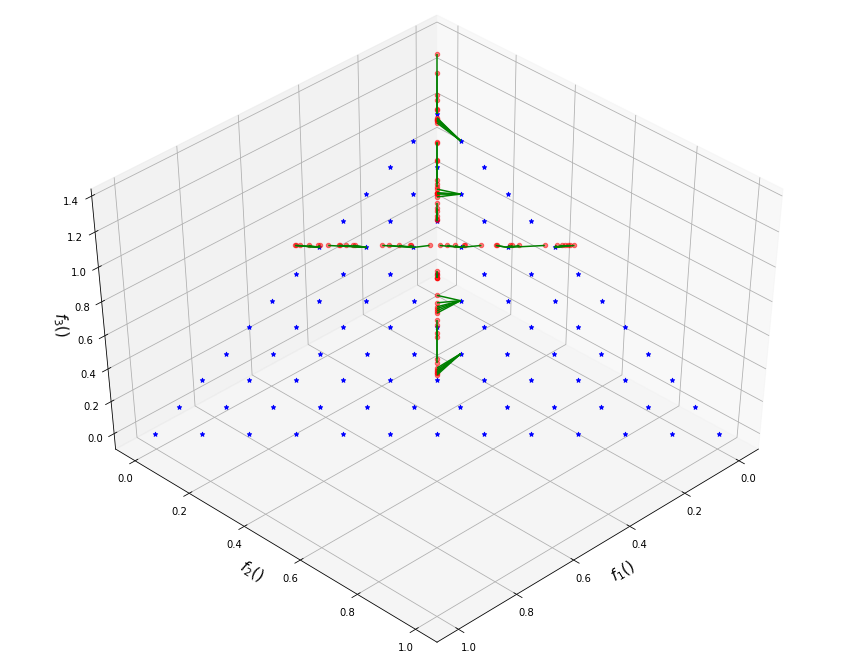

In [70]:
#Visualization of associated  of lines
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
    ax.scatter(ind.normalized_values[0], 
               ind.normalized_values[1], 
               ind.normalized_values[2], color='red', marker='o',alpha=0.5)
    pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=45, azim=45)
plt.autoscale(tight=True)

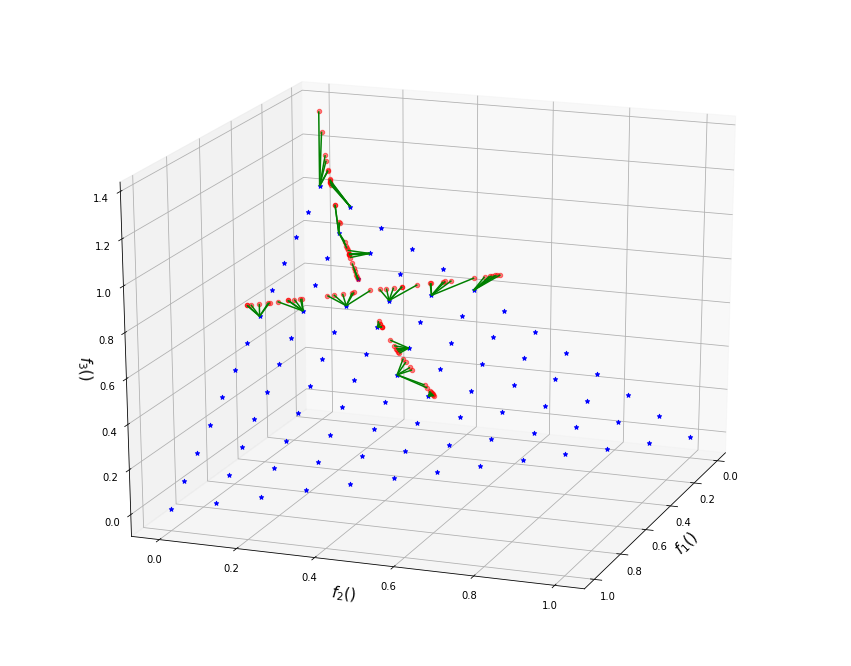

In [71]:
#Visualization of associated  of lines
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
# ax.scatter(0,0,0, c='k', marker='+', s=100)

# for ind in pop:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")

# for ind in individuals:
#     ax.scatter(ind[0],ind[1],ind[2],c="black")


for rp in reference_points:
    ax.scatter(rp[0], rp[1], rp[2], marker='*', c='blue')

pairs = []
for ind in pop:
    ax.scatter(ind.normalized_values[0], 
               ind.normalized_values[1], 
               ind.normalized_values[2], color='red', marker='o',alpha=0.5)
    pairs += [(ind.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('green')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=20, azim=20)
plt.autoscale(tight=True)